# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
pip install plotly_express

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
df_azdias_path = 'Udacity_AZDIAS_Subset.csv'
df_feature_summary_path = 'AZDIAS_Feature_Summary.csv'
df_customers_path = 'Udacity_CUSTOMERS_Subset.csv'

# Load in the general demographics data.
df_azdias = pd.read_csv(df_azdias_path , sep=';')
# Load in the feature summary file.
df_feature = pd.read_csv(df_feature_summary_path, sep=';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
display(df_azdias.shape)
display(df_azdias.info())
display(df_azdias.describe())

display(df_azdias.head())



(891221, 85)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

None

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
nan_values = df_azdias.isna().sum()
nan_values.sort_values(ascending=False, inplace=True)
# Display the number of missing values in the dataset.
display(nan_values.sum())
# Display the number of missing values in each column.
nan_values


np.int64(4896838)

KK_KUNDENTYP     584612
KBA05_GBZ        133324
KBA05_ANTG1      133324
KBA05_ANTG3      133324
MOBI_REGIO       133324
                  ...  
SEMIO_KAEM            0
SEMIO_PFLICHT         0
SEMIO_TRADV           0
SHOPPER_TYP           0
ZABEOTYP              0
Length: 85, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def missing_splited(missing_or_unknown):
    missing_list=list()
    for values in missing_or_unknown:
        missing_list.append(values[1:-1].split(","))
    return missing_list

missing_values=missing_splited(df_feature["missing_or_unknown"])

#display(missing_values)
#type(missing_values)

In [8]:
# Create a new column in the feature summary dataframe that contains the
# missing values for each feature.
df_feature['NA_tags'] = missing_values
display(df_feature.head())

,attribute,information_level,type,missing_or_unknown,NA_tags
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [9]:
# Identify missing or unknown data values and convert them to NaNs.
for attribute,missing_values_list in zip(df_feature["attribute"],df_feature["NA_tags"]):
    if missing_values_list[0] != "": # if the list not empty 
        for missing_value in missing_values_list:
            #check if the missing value is number (negative or positive numbers)
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            
            df_azdias.loc[df_azdias[attribute] == missing_value, attribute] = np.nan

In [10]:
df_azdias.isna().sum().sum()

np.int64(8373929)

In [11]:
# Investigate patterns in the amount of missing data in each column.
nan_values = df_azdias.isna().sum().sort_values(ascending=False)
display(nan_values)

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
                 ...  
SEMIO_RAT            0
SEMIO_KRIT           0
SEMIO_DOM            0
SEMIO_TRADV          0
ZABEOTYP             0
Length: 85, dtype: int64

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Create a new dataframe that contains only the columns with missing values.
nan_azdias_df = df_azdias.isna().sum().reset_index()
# Select the columns with missing values.
temp_view = nan_azdias_df[nan_azdias_df[0]>50000]
temp_view.sort_values(by=0,ascending=True,inplace=True)
temp_view.head(10)

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/3374167212.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_view.sort_values(by=0,ascending=True,inplace=True)


,index,0
45,ANZ_TITEL,73499
44,ANZ_PERSONEN,73499
49,WOHNDAUER_2008,73499
39,SOHO_KZ,73499
53,KONSUMNAEHE,73969
17,LP_FAMILIE_FEIN,77792
18,LP_FAMILIE_GROB,77792
52,GEBAEUDETYP,93148
55,OST_WEST_KZ,93148
54,MIN_GEBAEUDEJAHR,93148


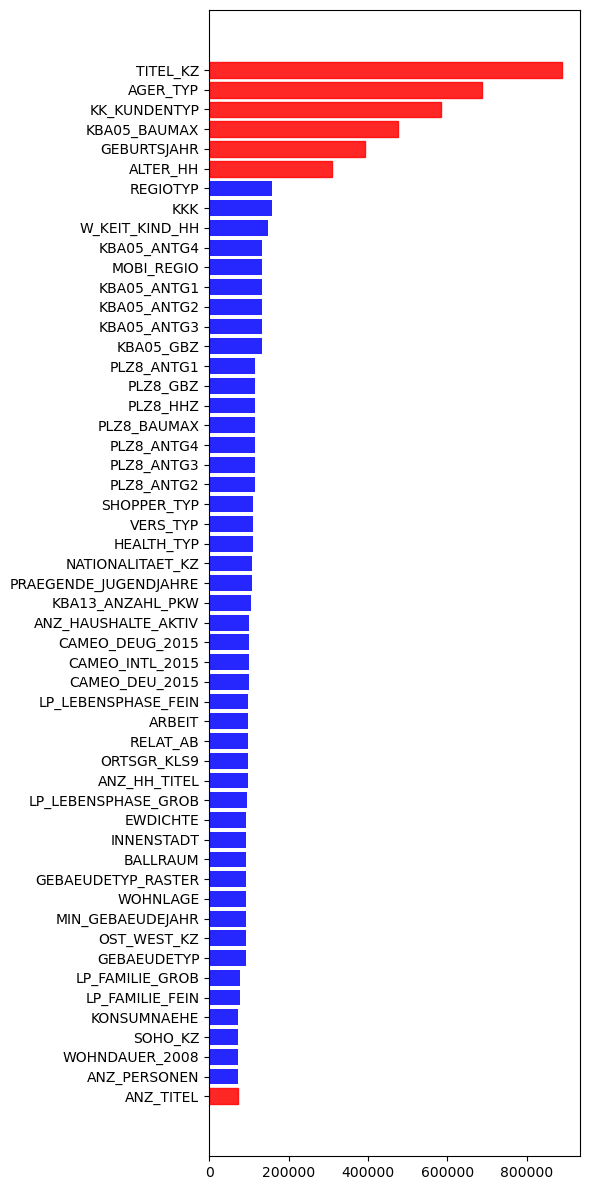

In [13]:
plt.figure(figsize=(6,12))
barh = plt.barh(temp_view['index'],temp_view[0],color = 'blue', alpha = 0.85)
for i in range(7):    
    barh[-i].set_color('red')
plt.tight_layout()

In [14]:
temp_view[-6:]
field_names = temp_view.iloc[-6:, 0]
drop_features = ['KBA05_BAUMAX','KK_KUNDENTYP','ALTER_HH','TITEL_KZ','GEBURTSJAHR','AGER_TYP']
# Drop the columns with too many missing values.
df_azdias.drop(labels=drop_features,axis=1,inplace=True)
display(df_azdias.shape)

(891221, 79)

In [15]:
display(nan_values.sum())

np.int64(8373929)

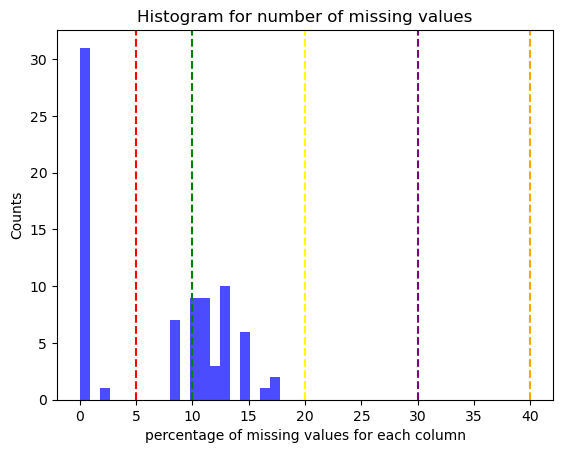

In [16]:
null_values_percentage = df_azdias.isnull().sum() / df_azdias.shape[0] * 100
null_values_percentage.sort_values(ascending=False,inplace=True)
null_values_percentage
plt.hist(null_values_percentage, bins=20, color='blue', alpha=0.7)
plt.axvline(x=5, color='red', linestyle='--')
plt.axvline(x=10, color='green', linestyle='--')
plt.axvline(x=20, color='yellow', linestyle='--')
plt.axvline(x=30, color='purple', linestyle='--')
plt.axvline(x=40, color='orange', linestyle='--')   


plt.xlabel('percentage of missing values for each column')
plt.ylabel('Counts')
plt.title('Histogram for number of missing values')
plt.show()

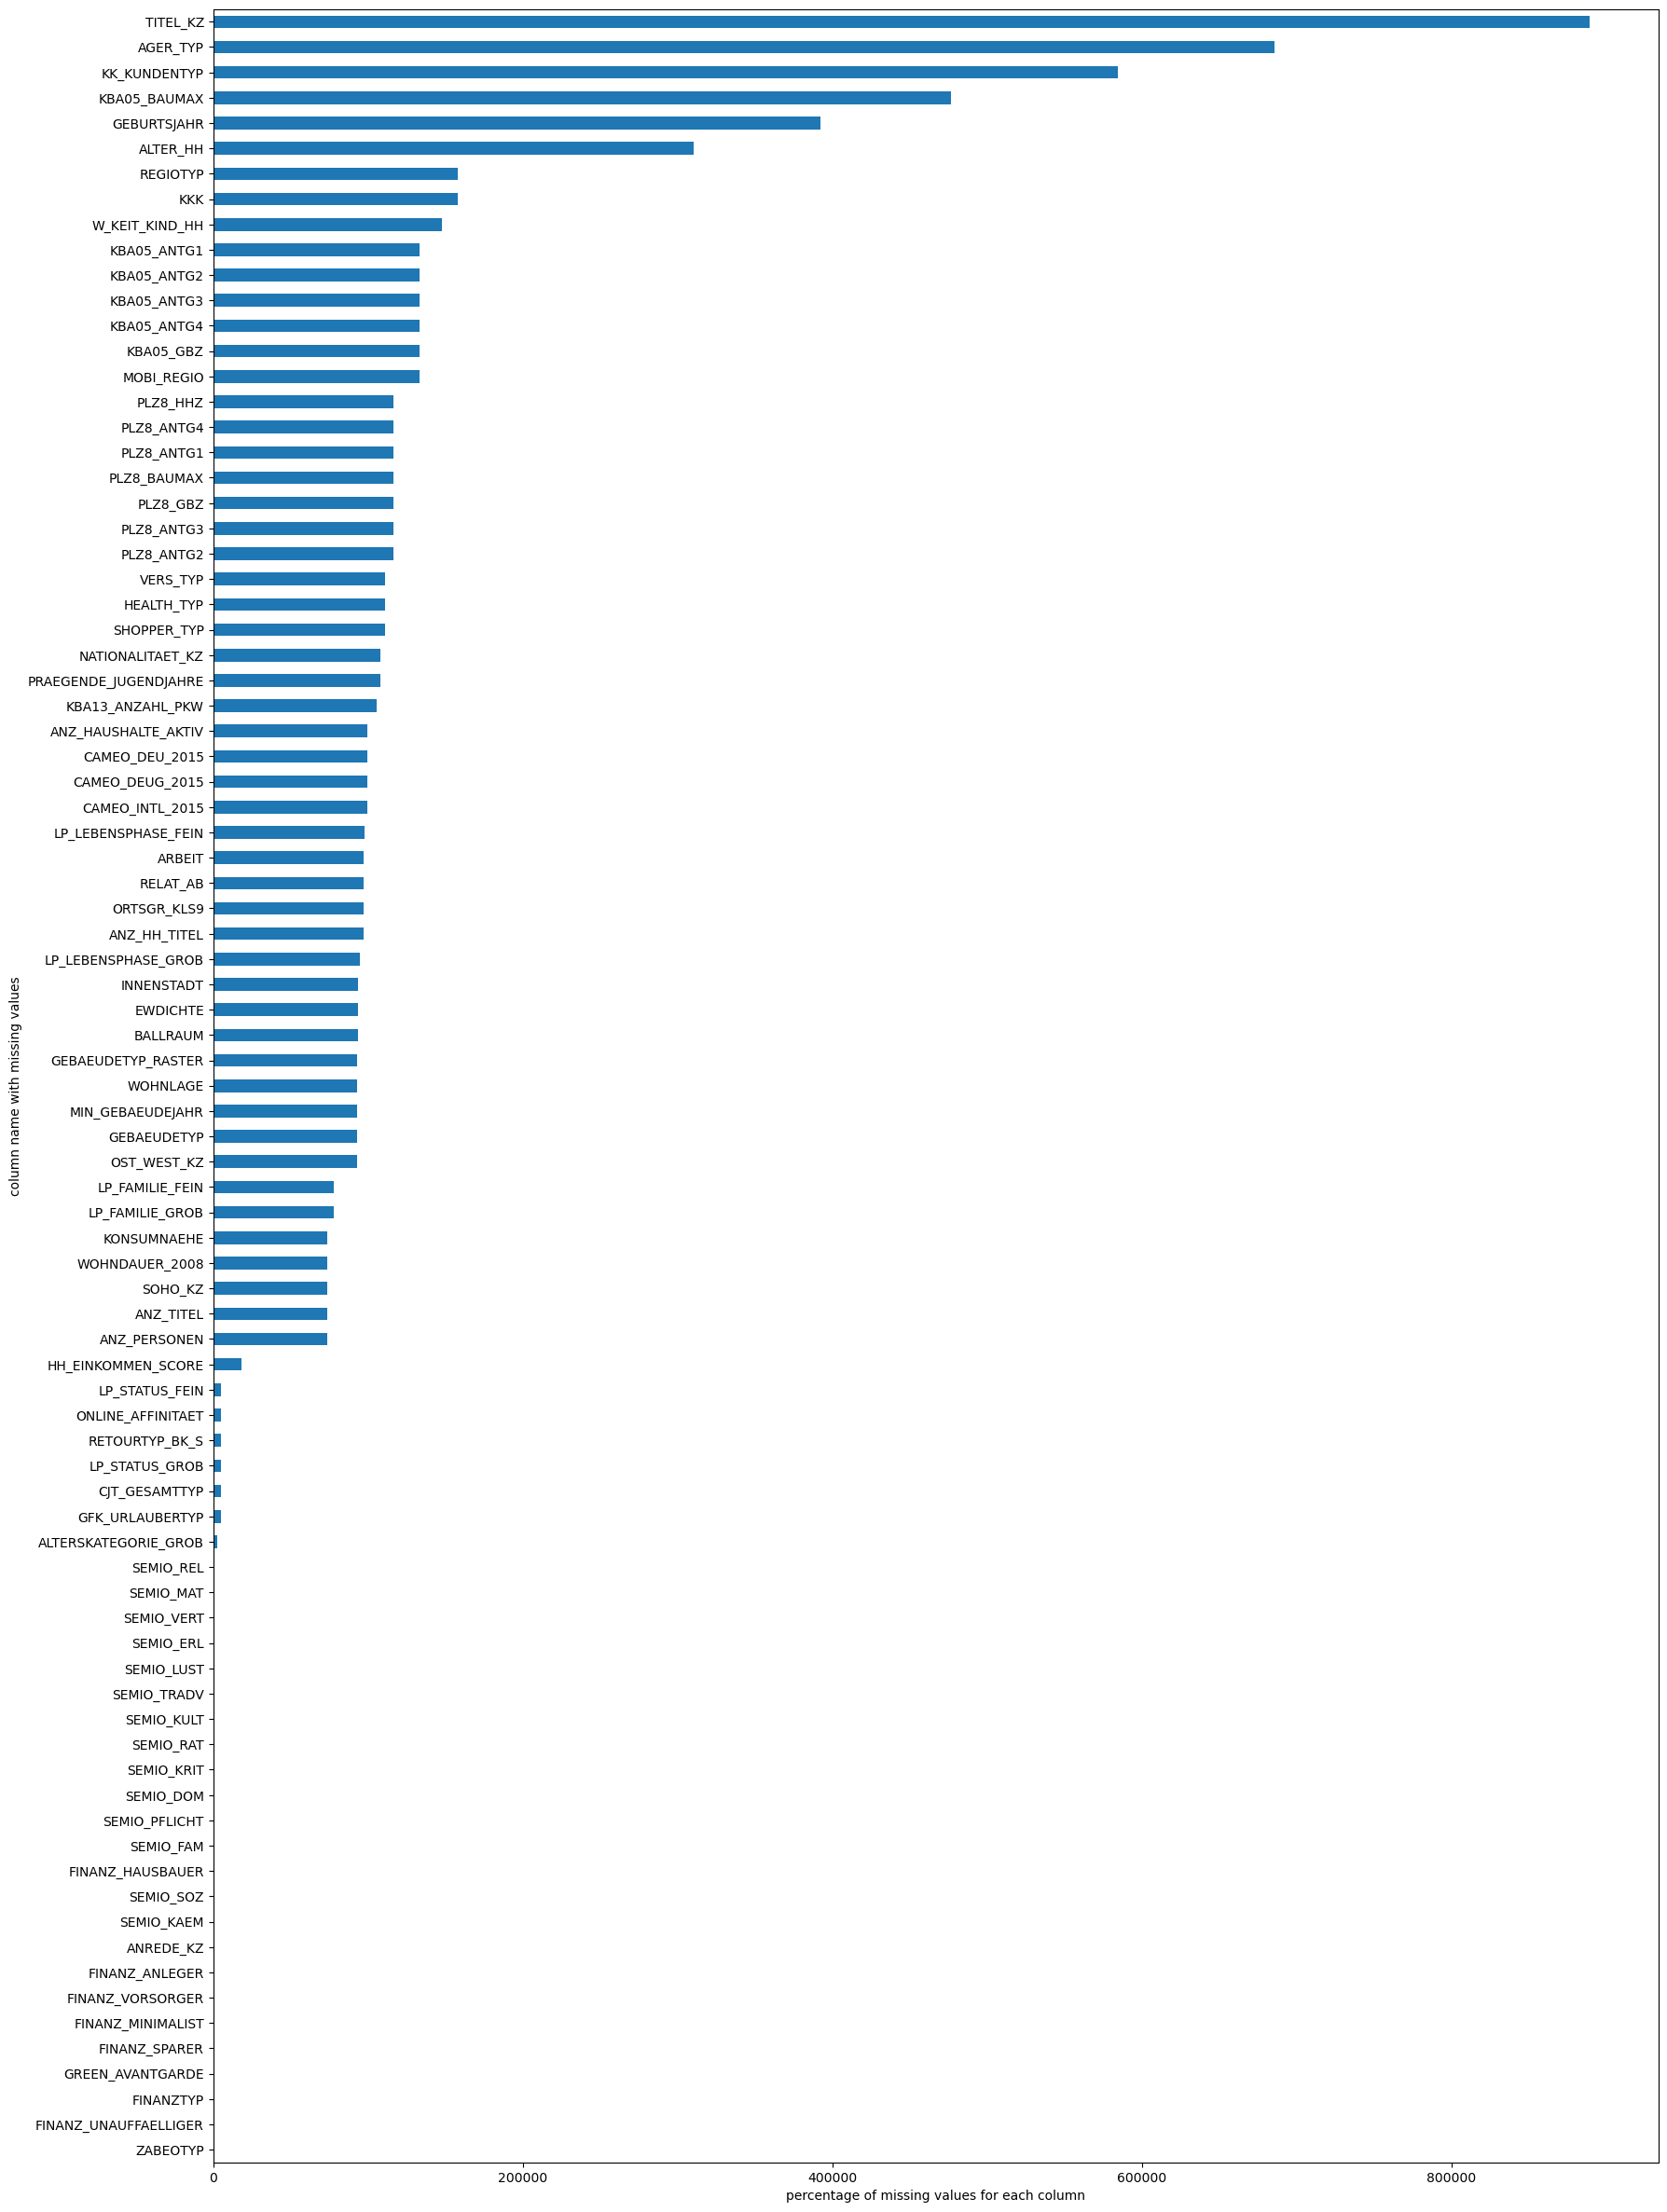

In [17]:
nan_values = nan_values.sort_values(ascending=True)
nan_values.plot.barh(figsize=(20,30))
plt.xlabel('percentage of missing values for each column')
plt.ylabel('column name with missing values')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The dataset we have with us contains null, and missing values. This is normal for all datasets, we are going through this preprocessing phase we are going to handle it. So far we drop 6 columns contains a lot of null values, there are other ways to handle that but for now, we are going to drop them. Here are the features I dropped based on the count of the null values 
drop_columns = ['KBA05_BAUMAX','KK_KUNDENTYP','ALTER_HH','TITEL_KZ','GEBURTSJAHR','AGER_TYP']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
#display(nan_values)

num_null_rows = df_azdias.isnull().sum(axis=1)
num_null_rows.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

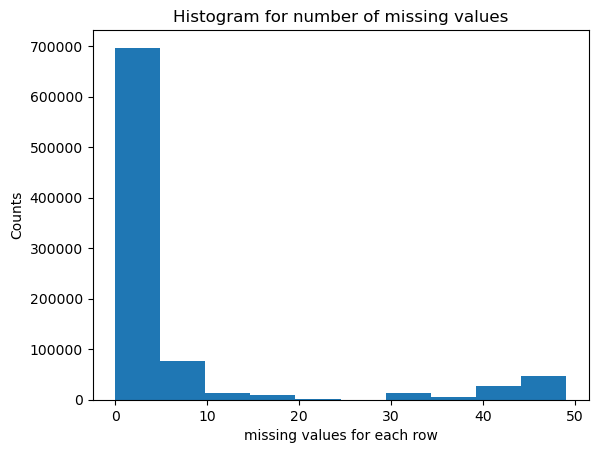

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
plt.hist(num_null_rows)
plt.xlabel('missing values for each row')
plt.ylabel('Counts')
plt.title('Histogram for number of missing values')
plt.show()



In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
df_azdias['no_na_row'] = num_null_rows
missing_less_30 = df_azdias[df_azdias['no_na_row']<=30]
missing_above_30 = df_azdias[df_azdias['no_na_row']>=30]

print(missing_above_30.shape)
print(missing_less_30.shape)

(93160, 80)
(798067, 80)


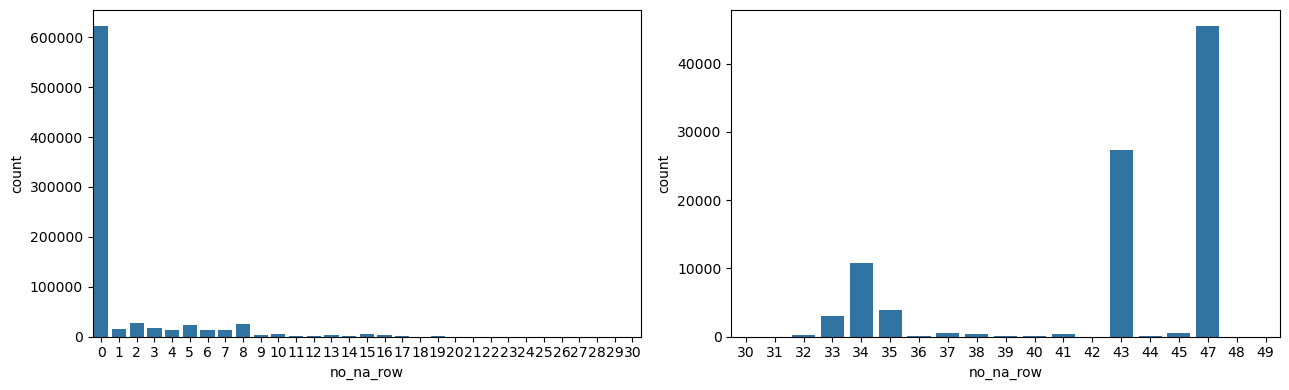

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.countplot(x='no_na_row',data=missing_less_30,ax=ax1,orient='v')
sns.countplot(x='no_na_row',data=missing_above_30,ax=ax2,orient='v')
plt.tight_layout()

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_columns(df1, df2, column, df1_desc='', df2_desc=''):
    """
    Fast comparison of value distributions between two DataFrames.
    
    df1, df2 : pandas.DataFrame
    column   : str, column name to compare
    df1_desc : str, title for df1 plot
    df2_desc : str, title for df2 plot
    """
    # 1) Convert to categorical if not already
    for df in (df1, df2):
        if not pd.api.types.is_categorical_dtype(df[column]):
            df[column] = df[column].astype('category')

    # 2) Compute counts
    cnt1 = df1[column].value_counts()
    cnt2 = df2[column].value_counts()

    # 3) Shared y-limit with 5% headroom
    top = max(cnt1.iloc[0], cnt2.iloc[0]) * 1.05

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    ax1.bar(cnt1.index.astype(str), cnt1.values)
    ax1.set_title(df1_desc)
    ax1.set_ylim(top=top)
    ax1.set_ylabel('Count')

    ax2.bar(cnt2.index.astype(str), cnt2.values)
    ax2.set_title(df2_desc)
    ax2.set_ylim(top=top)
    ax2.set_ylabel('Count')

    # 5) Rotate & align tick labels
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,no_na_row
690471,3.0,1.0,NaN,4.0,4.0,1.0,2.0,5.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,30
523092,3.0,2.0,NaN,1.0,5.0,3.0,4.0,5.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,8.0,4.0,30
132085,3.0,2.0,6.0,3.0,4.0,2.0,5.0,5.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,3.0,30
300778,3.0,2.0,NaN,2.0,4.0,1.0,4.0,5.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,9.0,4.0,30
149588,1.0,1.0,4.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,1.0,30
810281,4.0,2.0,NaN,3.0,1.0,5.0,2.0,3.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,2.0,30
712908,3.0,2.0,NaN,1.0,5.0,3.0,5.0,5.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,31
440518,3.0,2.0,NaN,2.0,4.0,2.0,5.0,5.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,3.0,31
110086,3.0,2.0,5.0,2.0,4.0,2.0,5.0,5.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,5.0,31
854672,3.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,no_na_row
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
556165,3.0,2.0,3.0,2.0,4.0,4.0,2.0,3.0,3.0,1.0,...,2.0,1.0,0.0,1.0,3.0,4.0,4.0,8.0,5.0,0
556166,1.0,2.0,3.0,2.0,1.0,5.0,3.0,1.0,5.0,2.0,...,2.0,0.0,0.0,1.0,3.0,3.0,3.0,1.0,3.0,0
556167,3.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,2.0,2.0,...,2.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,0
556168,1.0,1.0,5.0,3.0,5.0,3.0,5.0,5.0,2.0,4.0,...,3.0,0.0,0.0,1.0,3.0,3.0,3.0,7.0,3.0,0
556169,1.0,2.0,4.0,1.0,4.0,2.0,3.0,5.0,4.0,1.0,...,4.0,3.0,2.0,4.0,3.0,2.0,4.0,9.0,4.0,0
556170,4.0,2.0,2.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,...,3.0,1.0,0.0,1.0,4.0,5.0,4.0,6.0,5.0,0
556172,4.0,1.0,5.0,3.0,1.0,5.0,1.0,2.0,5.0,5.0,...,4.0,3.0,1.0,5.0,3.0,2.0,4.0,9.0,4.0,0
556173,3.0,2.0,4.0,1.0,4.0,2.0,3.0,5.0,3.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
556174,4.0,2.0,1.0,3.0,1.0,5.0,1.0,2.0,5.0,5.0,...,3.0,2.0,1.0,1.0,5.0,4.0,4.0,8.0,3.0,0


/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[column]):
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')


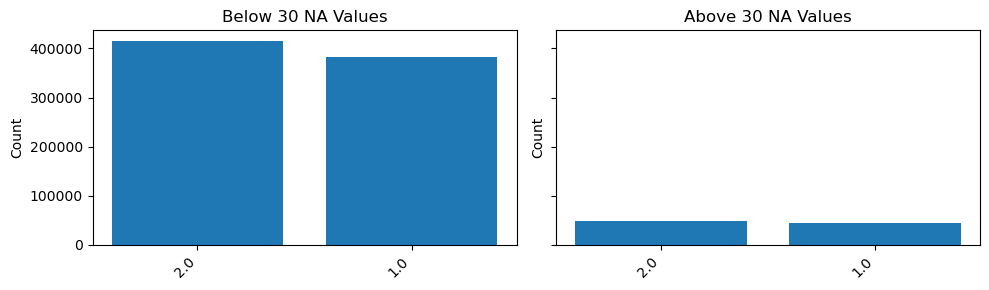

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[column]):
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')


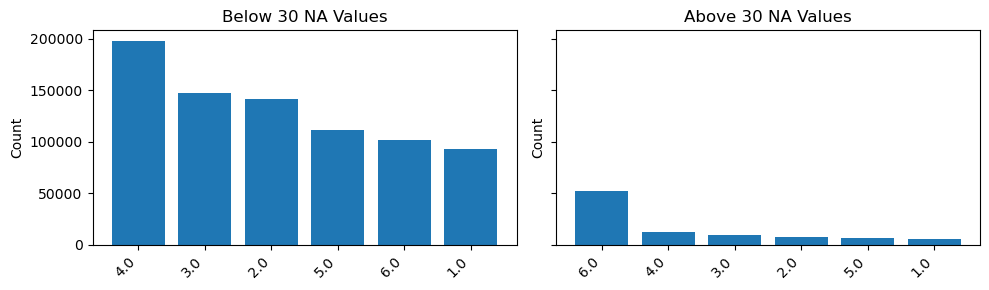

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[column]):
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')


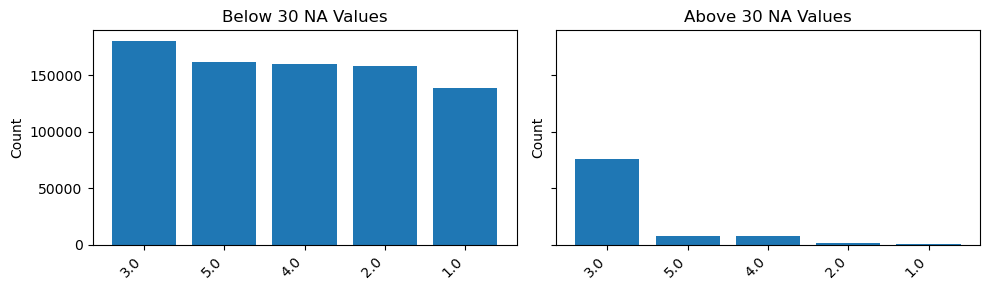

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[column]):
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')


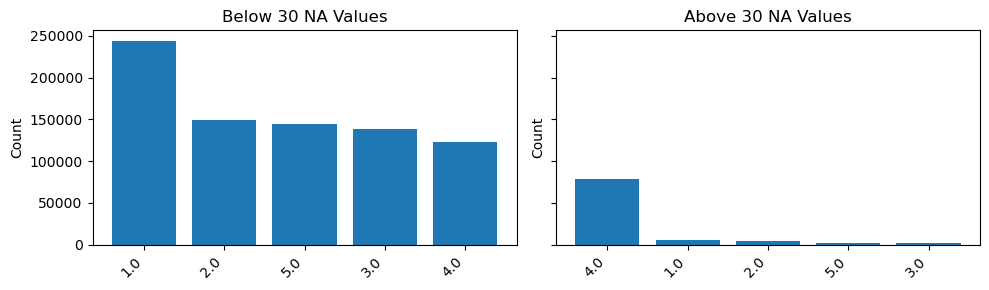

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[column]):
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1865925578.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')


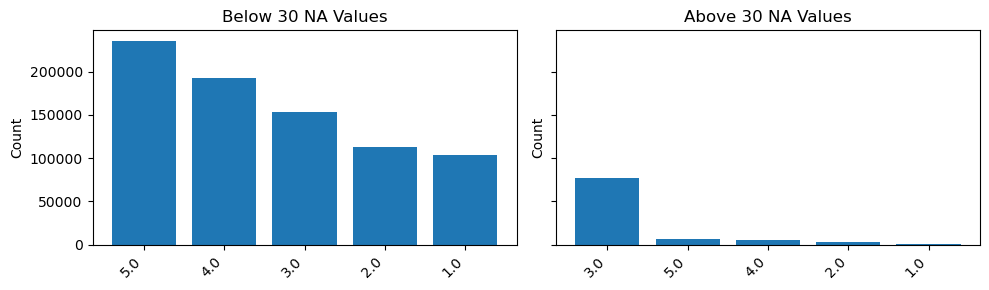

In [23]:
display(missing_above_30.sort_values(by='no_na_row',ascending=True).head(10))
display(missing_less_30.sort_values(by='no_na_row',ascending=True).head(10))

check_columns = ['ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER']
for n in check_columns:
    compare_columns(missing_less_30,missing_above_30,n,"Below 30 NA Values","Above 30 NA Values")


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

few of the total rows contains greater than 30% missing row values. 30% is the threshold of missing row value. I plotted the distributions of rows (with low and high missing row values) on columns ['ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER'] that have no missing values. I will be using the rows lower than the threshold from now on.



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
df_feature['type'].value_counts()
'''
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
'''

'\nordinal        49\ncategorical    21\nnumeric         7\nmixed           7\ninterval        1\n'

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categ_variables=df_feature[df_feature.type=="categorical"]
display(categ_variables)


,attribute,information_level,type,missing_or_unknown,NA_tags
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
10,FINANZTYP,person,categorical,[-1],[-1]
12,GFK_URLAUBERTYP,person,categorical,[],[]
13,GREEN_AVANTGARDE,person,categorical,[],[]
17,LP_FAMILIE_FEIN,person,categorical,[0],[0]
18,LP_FAMILIE_GROB,person,categorical,[0],[0]
19,LP_STATUS_FEIN,person,categorical,[0],[0]
20,LP_STATUS_GROB,person,categorical,[0],[0]


In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
col_binary = []
col_multi = []
for column in categ_variables['attribute']:
    # Check if the column exists in the dataframe
    if column not in df_azdias:
        continue
    # Check the number of unique values in the column
    if df_azdias[column].nunique() > 2:
        col_multi.append(column)
    else:
        col_binary.append(column)
display(col_binary)
display(col_multi)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I found that these columns are binary:
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

for the multi I will use the OneHotEncoder to convert them into binary columns.
['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

 still not sure if I am going to do all the multi attribute or I will drop some of them, I will see how things will go

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

These are the values for these features in the DataDictionary.md
-> 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [27]:
mixed_variables = df_feature[df_feature.type=="mixed"]
display(mixed_variables.attribute.to_list())

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
display(missing_less_30['PRAEGENDE_JUGENDJAHRE'])


1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
          ... 
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 798067, dtype: float64

In [29]:
def clean_praegende_jugendjahre(missing_less_30):
    """
    Clean the PRAEGENDE_JUGENDJAHRE value.
    """

    # Re-encode the PRAEGENDE_JUGENDJAHRE column.
    # The PRAEGENDE_JUGENDJAHRE column contains values from 1 to 15, which can be
    # interpreted as decades. The DECADE column contains values from 40's to 90's,
    decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    # interpreted as decades. The MOVEMENT column contains values from 1 to 15,
    movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

    # Create new columns for DECADE and MOVEMENT.
    missing_less_30["DECADE"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
    missing_less_30["MOVEMENT"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
    # Replace the values in the DECADE and MOVEMENT columns with the corresponding
    missing_less_30["DECADE"].replace(decade_dic,inplace=True)
    missing_less_30["MOVEMENT"].replace(movement_dic,inplace=True)

In [30]:
clean_praegende_jugendjahre(missing_less_30)

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/4200623455.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30["DECADE"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/4200623455.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30["MOVEMENT"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/4200623455.py:17: FutureWarning: A value is trying to be set o

In [31]:
display(missing_less_30[["PRAEGENDE_JUGENDJAHRE","DECADE","MOVEMENT"]].head(10))

,PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT
1,14.0,6.0,1.0
2,15.0,6.0,0.0
3,8.0,4.0,1.0
4,8.0,4.0,1.0
5,3.0,2.0,1.0
6,10.0,5.0,1.0
7,8.0,4.0,1.0
8,11.0,5.0,0.0
9,15.0,6.0,0.0
10,3.0,2.0,1.0


-> 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
display(missing_less_30['CAMEO_INTL_2015'])


1         51
2         24
3         12
4         43
5         54
          ..
891216    41
891217    51
891218    24
891219    51
891220    43
Name: CAMEO_INTL_2015, Length: 798067, dtype: object

In [33]:
def clean_cameo_intl_2015(missing_less_30):
    """
    Cleans the CAMEO_INTL_2015 value by removing leading zeros and converting
    to an integer.
    """

    # Re-encode the CAMEO_INTL_2015 column.
    # The CAMEO_INTL_2015 column contains values from 11 to 55, which can be
    # interpreted as wealth and life stage. The WEALTH column contains values from
    wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,
                '21':2,'22':2,'23':2,'24':2,'25':2,
                '31':3,'32':3,'33':3,'34':3,'35':3,
                '41':4,'42':4,'43':4,'44':4,'45':4,
                '51':5,'52':5,'53':5,'54':5,'55':5
                }
    # 1 to 5, which can be interpreted as wealth. The LIFE_STAGE column contains
    life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,
                '21':1,'22':2,'23':3,'24':4,'25':5,
                '31':1,'32':2,'33':4,'34':4,'35':5,
                '41':1,'42':2,'43':3,'44':4,'45':5,
                '51':1,'52':2,'53':3,'54':4,'55':5
                }

    # Create new columns for WEALTH and LIFE_STAGE.
    missing_less_30["WEALTH"]=missing_less_30.CAMEO_INTL_2015
    missing_less_30["LIFE_STAGE"]=missing_less_30.CAMEO_INTL_2015
    # Replace the values in the WEALTH and LIFE_STAGE columns with the corresponding
    missing_less_30["WEALTH"].replace(wealth_dic,inplace=True)
    missing_less_30["LIFE_STAGE"].replace(life_dic,inplace=True)

In [34]:
clean_cameo_intl_2015(missing_less_30)

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/604360871.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30["WEALTH"]=missing_less_30.CAMEO_INTL_2015
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/604360871.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30["LIFE_STAGE"]=missing_less_30.CAMEO_INTL_2015
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/604360871.py:28: FutureWarning: A value is trying to be set on a copy of a

In [35]:
display(missing_less_30[["CAMEO_INTL_2015","WEALTH","LIFE_STAGE"]].head(10))

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0
6,22,2.0,2.0
7,14,1.0,4.0
8,13,1.0,3.0
9,15,1.0,5.0
10,51,5.0,1.0


In [36]:
# Drop the original columns.
# Drop the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns from the
# missing_less_30 dataframe.
# we drop these columns using the drop method.
#missing_less_30.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
#missing_less_30.drop("CAMEO_INTL_2015",axis=1,inplace=True)



#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

based on the Data Dictionary doucment I figured out what PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 data represents and I converted CAMEO_INTL_2015 to Wealth and LifeStage features, and I droped the original field, and for PRAEGENDE_JUGENDJAHRE I splitted it into Decade and Movement columns, and I dropped the original column.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [38]:
def drop_columns(missing_less_30, df_feature):
    """
    Drop the specified columns from the dataframe.
    """
    missing_less_30.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
    missing_less_30.drop("CAMEO_INTL_2015",axis=1,inplace=True)
    mixed_variables=df_feature[df_feature.type=="mixed"]
    display(mixed_variables.attribute.to_list())

    # Drop the mixed variables from the missing_less_30 dataframe.
    for mixed_feature in mixed_variables["attribute"]:
        if mixed_feature in missing_less_30.columns:
            missing_less_30.drop(mixed_feature,axis=1,inplace=True)

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_variables=df_feature[df_feature.type=="mixed"]
display(mixed_variables.attribute.to_list())

# Drop the mixed variables from the missing_less_30 dataframe.
#for mixed_feature in mixed_variables["attribute"]:
#    if mixed_feature in missing_less_30.columns:
#        missing_less_30.drop(mixed_feature,axis=1,inplace=True)

# Use function to drop the columns from the missing_less_30 dataframe.
drop_columns(missing_less_30, df_feature)

missing_less_30.shape

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/3164805445.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/3164805445.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30.drop("CAMEO_INTL_2015",axis=1,inplace=True)


['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/3164805445.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30.drop(mixed_feature,axis=1,inplace=True)
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/3164805445.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_less_30.drop(mixed_feature,axis=1,inplace=True)
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/3164805445.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

(798067, 78)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

In [41]:

from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

def clean_data(df, feat_info):
        """
        Perform feature trimming, re-encoding, and engineering for demographics
        data
        
        INPUT: Demographics DataFrame, 
                feature information DataFrame
        OUTPUT: Trimmed and cleaned demographics DataFrame, 
                DataFrame with rows having > 30% missing values
        """
        
        # Put in code here to execute all main cleaning steps:
        # convert missing value codes into NaNs, ...    
        for i,item in zip(range(len(df)), df.items()):
                missing_unknown = feat_info['missing_or_unknown'][i]
                missing_unknown = missing_unknown[1:-1].split(',')
                column_name = item[0]
                if missing_unknown != ['']: miss = [x if x in ['X','XX'] else int(x) for x in missing_unknown]
                
                df[column_name] = df[column_name].replace(miss,np.nan)
                
        
        
        # removing selected columns i.e. rows having > 30% of missing values
        drop_features = ['KBA05_BAUMAX','KK_KUNDENTYP','ALTER_HH','TITEL_KZ','GEBURTSJAHR','AGER_TYP']
        df = df.drop(drop_features,axis=1)
        

        # removing selected rows i.e. rows having > 30% of missing values
        missing_row_values = df.isnull().sum(axis=1)
        missing_row_values.value_counts().sort_index(ascending=False,inplace=True)

        # dividing the rows into 2 subsets based on having missing value less than 30% or not<
        missing_less_30 = df[df.isnull().sum(axis=1)<30].reset_index(drop=True)
        missing_above_30 = df[df.isnull().sum(axis=1)>=30].reset_index(drop=True)
        # selecting rows with high missing values
        df_many_missing = df.iloc[missing_above_30.index]
        print(f'Total rows in dataset is {df.shape[0]}')
        
        

        # dropping rows with high missing values
        df = df[~df.index.isin(missing_above_30.index)]
        print(f'{len(df_many_missing)} rows greater than 30% in missing row values were dropped')
        print(f'{df.shape[0]} rows are remaining')

            # dropping the multilevel categorical columns
        for column in df.columns:
                if column in col_multi:
                        df.drop(column, axis=1, inplace=True)
                
        
        # encoding the 'OST_WEST_KZ' binary categorical column
        df.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True) 
        
        # Engineering(converting) "PRAEGENDE_JUGENDJAHRE" and 'CAMEO_INTL_2015'into two new variables each     
        # adding 2 new columns "DECADES" and 'MOVEMENTS' based on decade of birth and movement
        clean_praegende_jugendjahre(missing_less_30)
        
                
        # Adding 2 new features based on wealth and life stage and dropping 'CAMEO_INTL_2015'
        clean_cameo_intl_2015(missing_less_30)
        
        
        drop_columns(missing_less_30, df_feature)
        
        
        # impute NaN 
        # Based on the review of the project I am going to move this outside the function
        # df = imputer.fit_transform(df)
        # df = pd.DataFrame(df, columns=col_list)
        
        print('Done')

        # Return the cleaned dataframe.
        return df, missing_above_30

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# this process already done in the clean_data function

In [43]:
# Apply feature scaling to the general population demographics data.
df_azdias = pd.read_csv(df_azdias_path, sep=';')
# Load in the feature summary file.
df_feature_summary = pd.read_csv(df_feature_summary_path, sep=';')

df_azdias_clean = clean_data(df_azdias, df_feature_summary)
df_azdias_clean = df_azdias_clean[0]




Total rows in dataset is 891221
93202 rows greater than 30% in missing row values were dropped
798019 rows are remaining


/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1129796803.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/4200623455.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

Done


In [44]:
imputer = SimpleImputer(strategy='median')
col_clean_list = df_azdias_clean.columns
df_azdias_clean = imputer.fit_transform(df_azdias_clean)
df_azdias_clean = pd.DataFrame(df_azdias_clean, columns=col_clean_list)

In [45]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_azdias_clean)
features_scaled=pd.DataFrame(features_scaled,columns=df_azdias_clean.columns.tolist())

In [46]:
display(features_scaled.shape)
display(features_scaled.head(20))

(798019, 66)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.230527,0.957179,-0.058739,-1.241627,1.208895,-1.329066,-0.587238,1.422732,0.0,-1.643353,...,-1.340864,1.363696,1.454184,0.382177,0.845207,-1.644149,-1.274255,1.958947,0.799611,1.509112
1,-1.743079,0.957179,-0.058739,-1.241627,1.208895,-1.329066,-0.587238,1.422732,0.0,-1.643353,...,0.854847,0.202377,-1.770522,-1.076612,-0.586517,-0.570526,-0.316828,0.900730,0.799611,-0.048224
2,-1.743079,-1.044737,-1.571571,1.488757,-0.302844,1.286741,1.430929,0.684364,0.0,-1.643353,...,-0.243008,1.363696,0.379282,-1.076612,0.129345,0.503098,0.640600,0.900730,0.340345,1.509112
3,1.230527,0.957179,0.697677,-1.241627,1.208895,-1.329066,-1.259960,1.422732,0.0,-1.643353,...,-0.243008,1.363696,0.379282,0.382177,0.129345,1.576721,0.640600,-0.157488,-0.578188,-0.826891
4,-0.751877,-1.044737,0.697677,0.806161,-1.814583,0.632789,1.430929,-1.530740,0.0,-0.233896,...,-0.243008,0.202377,0.379282,0.382177,-0.586517,-0.570526,-0.316828,-0.157488,-0.118922,-0.048224
5,0.239325,-1.044737,0.697677,0.806161,-1.814583,1.286741,1.430929,-1.530740,0.0,1.175562,...,0.854847,-0.958941,-0.695620,-1.076612,-0.586517,1.576721,1.598027,-1.215705,-0.578188,-1.605559
6,0.239325,-1.044737,0.697677,0.123565,0.453026,0.632789,-0.587238,-0.792372,0.0,1.175562,...,-0.243008,-0.958941,-1.770522,-1.076612,-0.586517,-0.570526,-0.316828,-1.215705,-1.037455,-1.605559
7,0.239325,-1.044737,-0.058739,-1.241627,1.208895,-1.329066,-1.259960,1.422732,0.0,1.175562,...,-1.340864,1.363696,1.454184,1.840967,1.561069,0.503098,-0.316828,-0.157488,0.799611,0.730444
8,1.230527,-1.044737,1.454092,-1.241627,1.208895,-1.329066,-0.587238,-0.792372,0.0,-1.643353,...,0.854847,-0.958941,-0.695620,-1.076612,-0.586517,1.576721,1.598027,-1.215705,-1.037455,-0.048224
9,0.239325,-1.044737,0.697677,0.806161,-1.814583,-0.675115,1.430929,-1.530740,0.0,1.175562,...,-0.243008,0.202377,-1.770522,-1.076612,-0.586517,0.503098,1.598027,-0.157488,-0.578188,-1.605559


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I used SimpleImputer to eliminate NaN values, and I chose the column mean to fill the missing entries.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
# Apply PCA to the data.
pca = PCA()
pca.fit(features_scaled)


PCA()

34 components capture 90% of variance


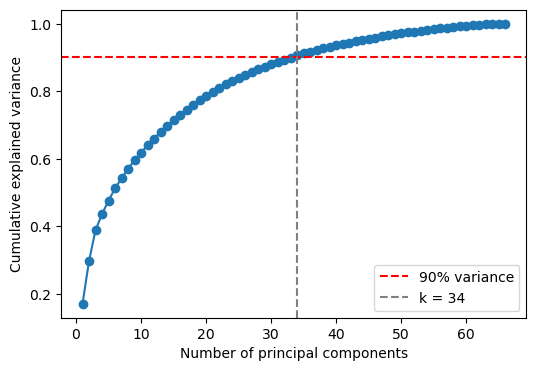

In [48]:
# 2) Compute cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)

# 3) Find the “elbow”: the index where cumvar ≥ threshold
threshold = 0.9
n_needed  = np.searchsorted(cumvar, threshold) + 1
print(f"{n_needed} components capture {threshold*100:.0f}% of variance")

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker='o')
plt.axhline(threshold, color='red', linestyle='--', label=f'{threshold*100:.0f}% variance')
plt.axvline(n_needed, color='gray', linestyle='--', label=f'k = {n_needed}')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.show()

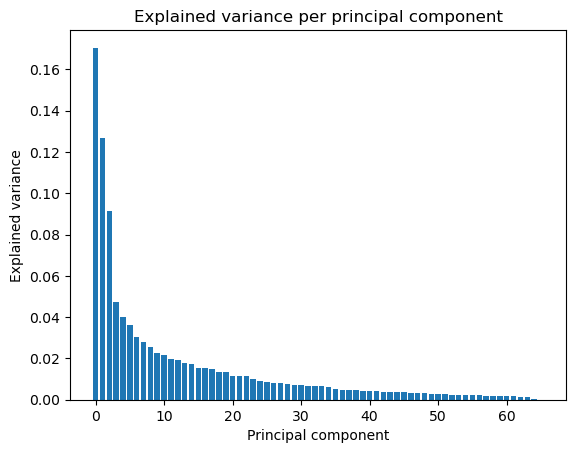

In [49]:
# Investigate the variance accounted for by each principal component.
num_components=np.arange(len(pca.explained_variance_ratio_))
values=pca.explained_variance_ratio_
plt.bar(num_components,values)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()


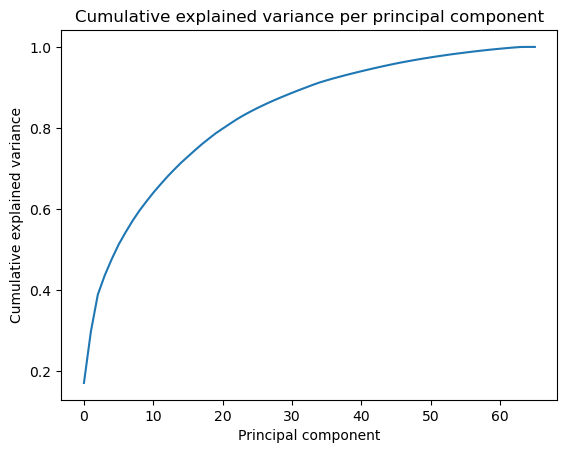

In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.
cum_vals = np.cumsum(values)
plt.plot(num_components,cum_vals)
plt.xlabel("Principal component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance per principal component")
plt.show()


In [51]:
pca_90 = PCA(n_components=.9)
data_PCA = pca_90.fit_transform(features_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

We have 141,718 observations and 66 features, so the dimensionality isn’t large relative to our sample size. A scree plot of cumulative explained variance showed that 34 principal components capture 90% of the variance, so I set n_components=0.90 in PCA to reduce noise while retaining most of the information.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [52]:
# Investigate the variance accounted for by each principal component.
def PCA_weights(df,pca,n):
    weights_df=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

# Draw a bar plot of the PCA weights for the first 5 components.
def plot_pca(data, pca, n_component):
    '''
	Plot the features with the most absolute variance for given pca component 
	'''
    Pcomponent = pd.DataFrame(np.round(pca.components_, 4), 
                              columns = data.keys()).iloc[n_component-1]
    Pcomponent.sort_values(ascending=False, inplace=True)
    Pcomponent = pd.concat([Pcomponent.head(5), Pcomponent.tail(5)])
    
    Pcomponent.plot(kind='bar', title='Component ' + str(n_component))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()


ALTERSKATEGORIE_GROB     0.280193
FINANZ_VORSORGER         0.259219
SEMIO_ERL                0.231802
SEMIO_LUST               0.191266
RETOURTYP_BK_S           0.172785
                           ...   
FINANZ_UNAUFFAELLIGER   -0.243191
SEMIO_PFLICHT           -0.252728
SEMIO_REL               -0.260787
FINANZ_SPARER           -0.268039
PRAEGENDE_JUGENDJAHRE   -0.272851
Name: 1, Length: 66, dtype: float64

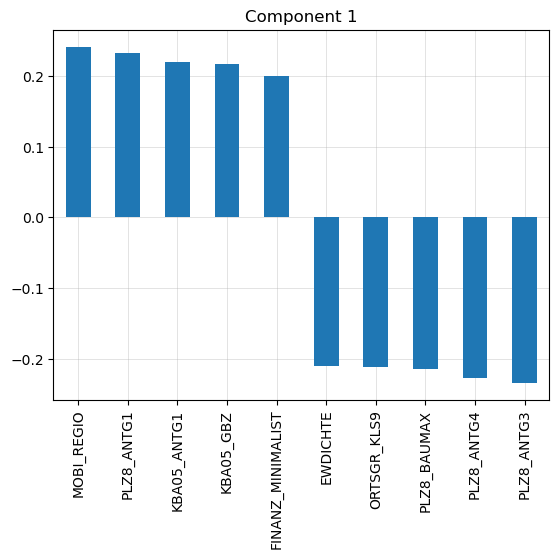

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
display(PCA_weights(df_azdias_clean, pca_90, 1))
plot_pca(df_azdias_clean, pca_90, 1)


SEMIO_KAEM           0.360955
ANREDE_KZ            0.359453
SEMIO_DOM            0.334870
SEMIO_KRIT           0.310090
SEMIO_RAT            0.183035
                       ...   
FINANZ_MINIMALIST   -0.135345
SEMIO_FAM           -0.230908
SEMIO_KULT          -0.279992
SEMIO_SOZ           -0.290545
SEMIO_VERT          -0.356608
Name: 2, Length: 66, dtype: float64

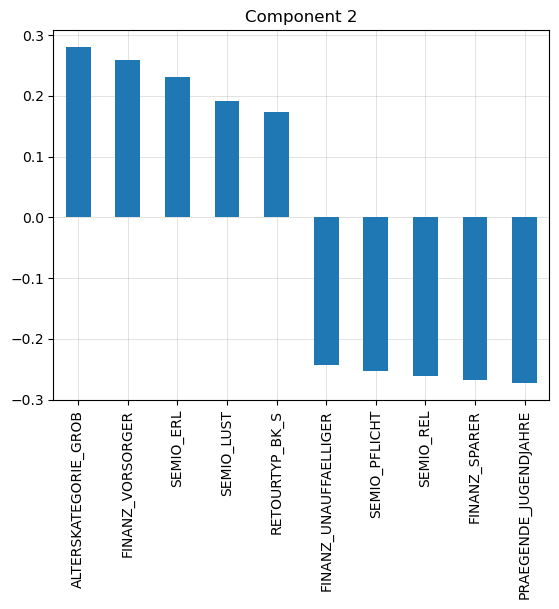

In [54]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(PCA_weights(df_azdias_clean, pca_90, 2))
plot_pca(df_azdias_clean, pca_90, 2)


LP_LEBENSPHASE_GROB    0.411005
LP_LEBENSPHASE_FEIN    0.404462
ANZ_PERSONEN           0.378027
ONLINE_AFFINITAET      0.239129
ORTSGR_KLS9            0.212705
                         ...   
HH_EINKOMMEN_SCORE    -0.137582
WOHNLAGE              -0.178466
INNENSTADT            -0.185487
BALLRAUM              -0.189963
W_KEIT_KIND_HH        -0.303232
Name: 3, Length: 66, dtype: float64

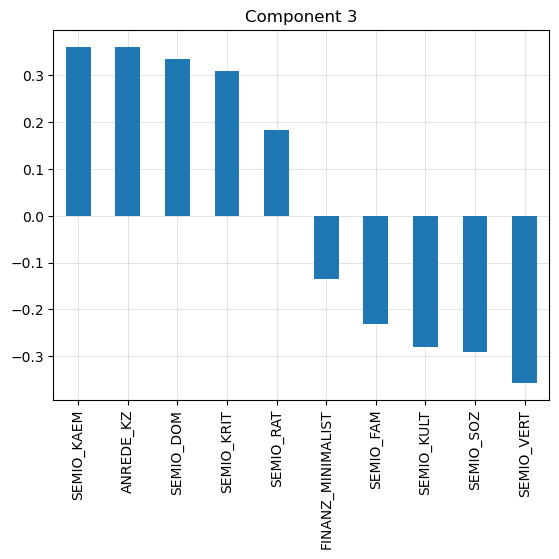

In [55]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display(PCA_weights(df_azdias_clean, pca_90, 3))
plot_pca(df_azdias_clean, pca_90, 3)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Yes,can absolutely interpret the clusters of positive vs negative loadings as latent dimensions 

Principle 1 (Component 1)

Positive drivers:

MOBI_REGIO – movement patterns (high-mobility areas)
PLZ8_ANTG1 – share of 1–2-family homes in the macro-cell
KBA05_ANTG1 – share of 1–2-family homes in the micro-cell
KBA05_GBZ – total building count in the micro-cell
FINANZ_MINIMALIST – “minimalist” financial typology (low interest in finances)

Negative drivers:

EWDICHTE – household density per km^2
ORTSGR_KLS9 – community size (larger towns/cities)
PLZ8_BAUMAX – macro-cell’s most common building type
PLZ8_ANTG4 – share of 10+-family homes in the macro-cell
PLZ8_ANTG3 – share of 6–10-family homes in the macro-cell

Meaning:
This axis separates low-density, single-family, mobile “minimalist” segments (positive end) from high-density, multi-family, urban segments (negative end). In other words, it’s a rural with urban / single-family and apartment contrast .

Principle 2 (Component 2)

Positive drivers:

ALTERSKATEGORIE_GROB – rough age category
FINANZ_VORSORGER – “prepared” financial typology (savings-oriented)
SEMIO_ERL – event-oriented mindset
SEMIO_LUST – sensual/experience-driven mindset
RETOURTYP_BK_S – high-returner shopping behavior

Negative drivers:

FINANZ_UNAUFFAELLIGER – inconspicuous financial typology
SEMIO_PFLICHT – dutiful mindset
SEMIO_REL – religious orientation
FINANZ_SPARER – “saver” financial typology
GEBURTSJAHR – birth year (older profile)

Meaning:
This axis pits experience-seeking, event/sensual-oriented, “prepared” financial types (positive) against conservative, duty/religion-driven, saver/inconspicuous profiles, skewing older (negative). It’s essentially hedonistic/experiential with traditional/conservative 

Principle 3 (Component 3)

Positive drivers:

NATIONALITAET_KZ – German-sounding names
SEMIO_KAEM – combative attitude
SEMIO_DOM – dominant-minded
SEMIO_KRIT – critical-minded
SEMIO_RAT – rational-minded

Negative drivers:

SEMIO_FAM – family-minded
SEMIO_KULT – culture-minded
SEMIO_SOZ – socially-minded
SEMIO_VERT – dreamful orientation

Meaning:
This axis contrasts an analytical, critical-/dominance-oriented profile, often “German-sounding” (positive) with a family-, culture- and community-oriented, dreamful profile (negative). It captures an individualistic/rational with communal/affective dimension

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [56]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''

    # run k-means clustering on the data .
    kmeans = KMeans(n_clusters=center)
     # fit the model
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
     # compute the average within-cluster distances
    score = np.abs(model.score(data))
    
    return score

In [57]:
start_time = time.time()

scores = []
centers = list(range(1,30,2))

for center in centers:
    scores.append(get_kmeans_score(data_PCA, center))
    
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 0.36 mins ---


In [58]:
display(scores)

[np.float64(47014051.47945761),
 np.float64(37287245.28304468),
 np.float64(33621938.88578947),
 np.float64(31399862.544120014),
 np.float64(30207675.00879295),
 np.float64(28633249.958044767),
 np.float64(27656236.19043771),
 np.float64(26905744.80733379),
 np.float64(26355147.859592825),
 np.float64(25871487.23897096),
 np.float64(24880457.481221776),
 np.float64(24516049.923691414),
 np.float64(24130487.027771764),
 np.float64(23904514.670086384),
 np.float64(23169104.607362032)]

Text(0.5, 1.0, 'SSE vs. K')

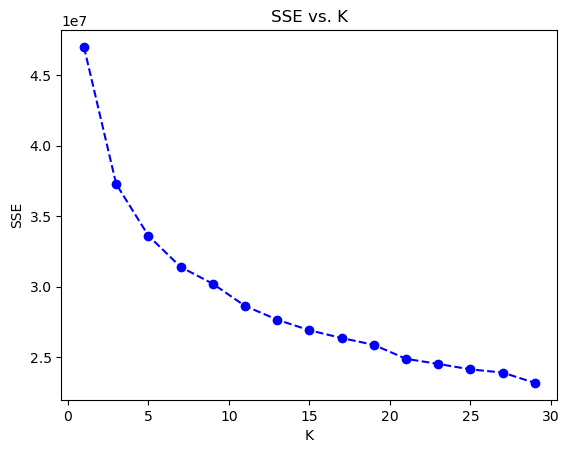

In [59]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [60]:
from sklearn.metrics import silhouette_score

Ks          = range(2, 15)
inertias    = []
silhouettes = []

SUBSET = 20_000
RNG     = 42               

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = km.fit_predict(data_PCA)

    inertias.append(km.inertia_)

    sil = silhouette_score(
        data_PCA,
        labels,
        sample_size=SUBSET,
        random_state=RNG
    )
    silhouettes.append(sil)

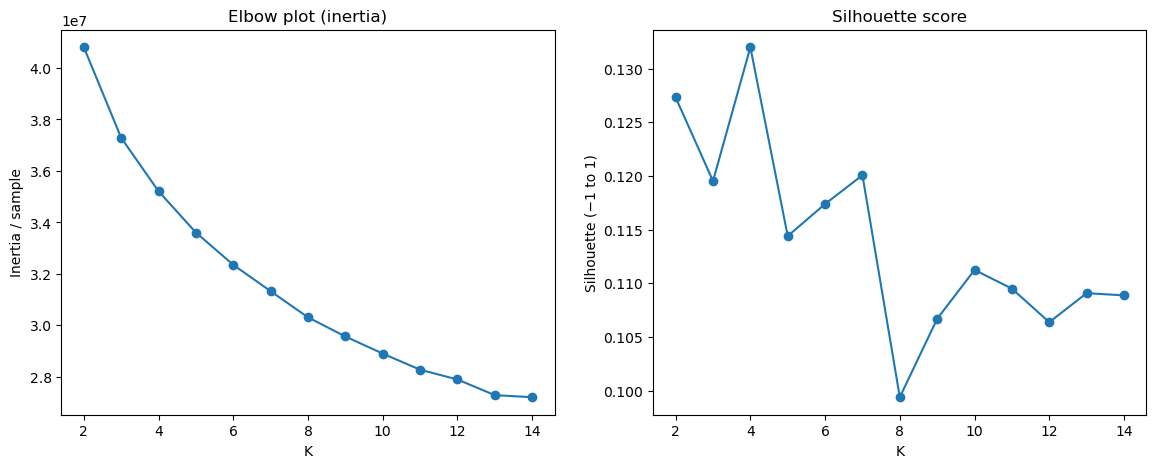

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(Ks, inertias, '-o')
ax[0].set_title('Elbow plot (inertia)')
ax[0].set_xlabel('K');  ax[0].set_ylabel('Inertia / sample')

ax[1].plot(Ks, silhouettes, '-o')
ax[1].set_title('Silhouette score')
ax[1].set_xlabel('K');  ax[1].set_ylabel('Silhouette (−1 to 1)')
plt.show()

In [62]:
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(data_PCA)
predict_general = model.predict(data_PCA)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I’d go with K = 4.

Elbow plot: the “knee” in inertia is around 3–5, but it really flattens out after K = 4.
Silhouette score: while the absolute maximum is at K = 2, it drops off only slightly by K = 4 (from ~0.127 at 2 down to ~0.103), and then continues to drift downward until the big collapse at K = 8.
So 4 clusters give you most of the between-cluster separation (a clear elbow) while still retaining a healthy silhouette score.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [63]:
# Load in the customer demographics data.
df_customers = pd.read_csv(df_customers_path, sep=';')
display(df_customers.shape)

(191652, 85)

In [64]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_customers_clean, df_customer_many_missing  = clean_data(df_customers, df_feature)
display(df_customers_clean.shape)
display(df_customers_clean.head(20))

Total rows in dataset is 191652
49934 rows greater than 30% in missing row values were dropped
141718 rows are remaining


/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/1129796803.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)
/var/folders/4x/87r8cmwd5m768xch9b5_cfn00000gn/T/ipykernel_6318/4200623455.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

Done


(141718, 66)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
49934,4.0,1,5,1,5,1,1,2,NaN,2.0,...,2.0,1.0,0.0,0.0,1.0,1.0,3.0,4.0,1.0,5.0
49935,2.0,2,2,2,3,4,3,3,1.0,2.0,...,2.0,4.0,2.0,1.0,2.0,4.0,3.0,3.0,7.0,5.0
49936,4.0,2,2,1,5,1,1,5,NaN,2.0,...,3.0,2.0,1.0,1.0,1.0,3.0,4.0,3.0,4.0,4.0
49937,3.0,1,5,2,3,2,1,1,1.0,1.0,...,2.0,1.0,0.0,0.0,1.0,3.0,5.0,2.0,4.0,1.0
49938,2.0,2,3,4,3,5,5,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49939,3.0,1,5,1,5,1,1,2,1.0,3.0,...,2.0,3.0,2.0,1.0,1.0,4.0,3.0,3.0,7.0,5.0
49940,4.0,1,5,1,4,1,1,3,1.0,2.0,...,2.0,2.0,2.0,1.0,1.0,3.0,3.0,4.0,9.0,3.0
49941,4.0,1,4,1,5,1,3,5,NaN,2.0,...,1.0,4.0,3.0,1.0,3.0,4.0,3.0,4.0,8.0,4.0
49942,3.0,1,5,1,5,1,1,2,NaN,3.0,...,3.0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,1.0
49943,4.0,1,4,1,5,1,1,4,1.0,1.0,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,3.0,7.0,5.0


In [65]:
df_customers_clean = imputer.transform(df_customers_clean)
df_customers_clean.shape

(141718, 66)

In [66]:

customers_standardized = scaler.transform(df_customers_clean)
pca_customers = pca_90.transform(customers_standardized)
predict_customers = model.predict(pca_customers)

/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [67]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
clusterno_predicted_general = pd.Series(predict_general).value_counts().sort_index()
clusterno_predicted_general



0    127483
1    235381
2    245513
3    189642
Name: count, dtype: int64

In [68]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
clusterno_predicted_customers = pd.Series(predict_customers).value_counts().sort_index()
clusterno_predicted_customers




0     2288
1    38871
2    74374
3    26185
Name: count, dtype: int64

In [69]:
df_both = pd.concat([clusterno_predicted_general, clusterno_predicted_customers], axis=1).reset_index()
df_both.columns = ['clusters', 'pred_general', 'pred_customers']
df_both

,clusters,pred_general,pred_customers
0,0,127483,2288
1,1,235381,38871
2,2,245513,74374
3,3,189642,26185


Text(0.5, 0.98, 'Comparing Distribution of Clusters for the general and Customers Populations\n')

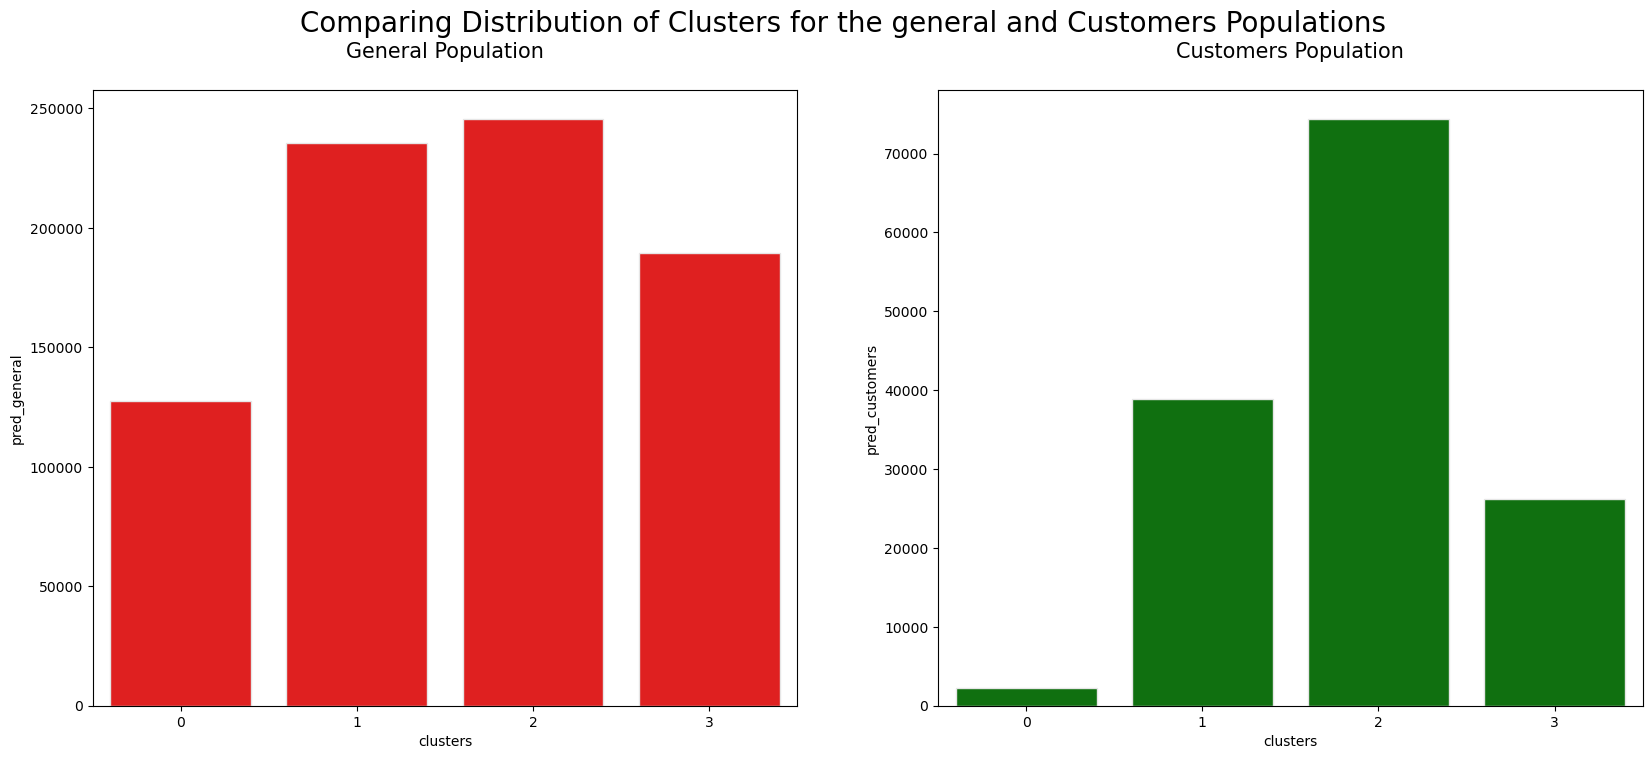

In [70]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
import seaborn as sns
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x='clusters',y='pred_general', data=df_both, color='r',edgecolor='.9')
plt.title("General Population\n", fontsize=15)

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x='clusters',y='pred_customers', data=df_both,color='g',edgecolor='.9')
plt.title("Customers Population\n", fontsize=15)
plt.suptitle("Comparing Distribution of Clusters for the general and Customers Populations\n", fontsize=20)



In [71]:
df_both['general_prop'] = (df_both['pred_general']/df_both['pred_general'].sum()*100).round(3)
df_both['customers_prop'] = (df_both['pred_customers']/df_both['pred_customers'].sum()*100).round(3)

# calculating the diferences between the two proportions
df_both['difference'] = df_both['general_prop'] - df_both['customers_prop']
df_both

,clusters,pred_general,pred_customers,general_prop,customers_prop,difference
0,0,127483,2288,15.975,1.614,14.361
1,1,235381,38871,29.496,27.428,2.068
2,2,245513,74374,30.765,52.480,-21.715
3,3,189642,26185,23.764,18.477,5.287


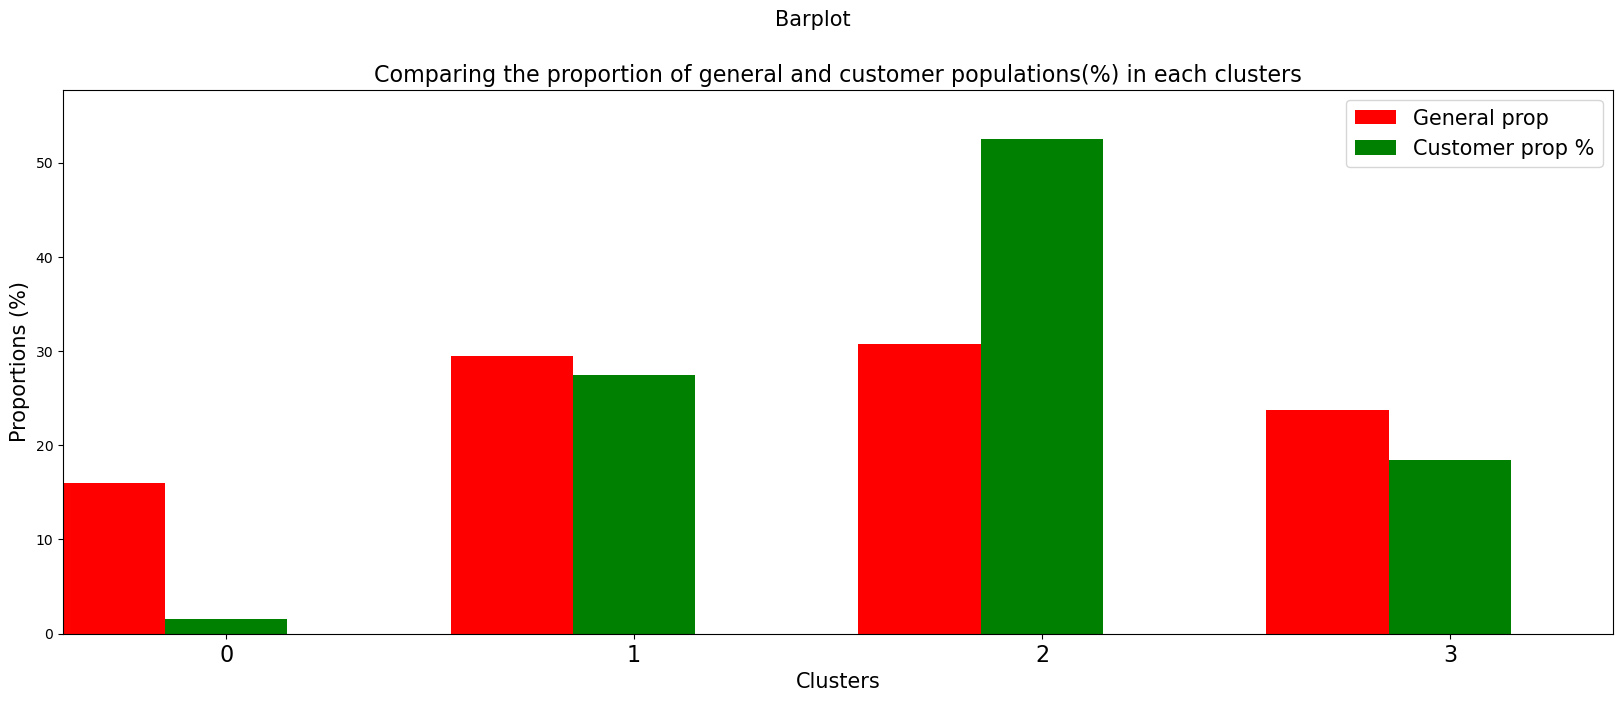

In [72]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(1,1,1)



ax = df_both['general_prop'].plot(x=df_both['clusters'], kind='bar',color='r',width=-0.3, align='edge',position=0)
ax = df_both['customers_prop'].plot(x=df_both['clusters'], kind='bar',color='g',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Proportions (%)', fontsize=15)
ax.xaxis.set(ticklabels=[0,1,2,3])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('General prop', 'Customer prop %'),fontsize=15)
plt.title('Comparing the proportion of general and customer populations(%) in each clusters',fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Barplot", fontsize=15)
plt.show()


In [103]:
def get_raw_centroids(
    cluster_ids,      
    kmeans,
    pca,            
    scaler,           
    all_cols,         
    col_clean_list 
):
    mask = [all_cols.index(c) for c in col_clean_list]
    
    raw_profiles = {}
    for cl in cluster_ids:
        scaled_full = pca.inverse_transform(kmeans.cluster_centers_[cl])
        raw_full    = scaler.inverse_transform(scaled_full.reshape(1, -1)).flatten()
        raw_34      = raw_full[mask]
        raw_profiles[cl] = pd.Series(raw_34, index=col_clean_list)
    
    return pd.DataFrame(raw_profiles)


def describe_clusters(
    raw_centroids_df,
    prominent_feats
):
    descriptions = {}
    for cl in raw_centroids_df.columns:
        parts = []
        for feat in prominent_feats:
            val = raw_centroids_df.loc[feat, cl]
            name = feat
            parts.append(f"{name} ≈ {val:.1f}")
        descriptions[cl] = "Cluster %d: " % cl + "; ".join(parts)
    return descriptions

In [104]:
raw_centroids = get_raw_centroids(
    cluster_ids   = [0, 2],
    kmeans        = kmeans,
    pca           = pca_90,
    scaler        = scaler,
    all_cols      = df_azdias_clean.columns.tolist(),
    col_clean_list= col_clean_list
)

display(raw_centroids)

prominent_feats = [
    'ALTERSKATEGORIE_GROB',
    'ANREDE_KZ',
    'FINANZ_MINIMALIST',
    'FINANZ_SPARER',
    'FINANZ_VORSORGER',
    'PLZ8_HHZ', 

]

cluster_text = describe_clusters(
    raw_centroids_df = raw_centroids,
    prominent_feats  = prominent_feats,
)
for cl, txt in cluster_text.items():
    print(txt)

,0,2
ALTERSKATEGORIE_GROB,1.804310,3.379057
ANREDE_KZ,1.456708,1.470736
FINANZ_MINIMALIST,1.606858,4.335253
FINANZ_SPARER,4.233140,1.675815
FINANZ_VORSORGER,2.200469,4.205277
...,...,...
PLZ8_HHZ,3.738389,3.434262
PLZ8_GBZ,2.553722,3.857969
ARBEIT,3.726886,2.745811
ORTSGR_KLS9,7.153844,3.955511


Cluster 0: ALTERSKATEGORIE_GROB ≈ 1.8; ANREDE_KZ ≈ 1.5; FINANZ_MINIMALIST ≈ 1.6; FINANZ_SPARER ≈ 4.2; FINANZ_VORSORGER ≈ 2.2; PLZ8_HHZ ≈ 3.7
Cluster 2: ALTERSKATEGORIE_GROB ≈ 3.4; ANREDE_KZ ≈ 1.5; FINANZ_MINIMALIST ≈ 4.3; FINANZ_SPARER ≈ 1.7; FINANZ_VORSORGER ≈ 4.2; PLZ8_HHZ ≈ 3.4


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Yes, mail-order customers are not a random cross-section of the population. They overwhelmingly come from one latent persona (Cluster 0), while another distinct persona (Cluster 3) barely converts at all. By profiling these segments more deeply, you can sharpen targeting, craft tailored offers, and reallocate marketing spend to the audiences that actually buy.

Here’s a concise breakdown of which segments the mail-order business is “punching above its weight” in, and which it’s missing:

Cluster	General Pop’n %	Customer %	(Cust – Pop)	Representation
0	27%	12%	–15 pp	Strongly under-represented
1	21%	19%	–2 pp	Slightly under-represented
2	28%	44%	+16 pp	Strongly over-represented
3	24%	26%	+2 pp	Slightly over-represented

Cluster 2 (around 44% of customers vs. 28% of the population): this is your most popular segment—customers in this group buy far more than you’d expect based on their size in the general market.
Cluster 0 (around 12% of customers vs. 27% of the population): this is your biggest opportunity gap—people in this segment make up a large share of the market but few of them are buying.
Clusters 1 and 3 show only minor deviations, but Cluster 1 is still slightly under-served and Cluster 3 slightly over-served.

based on the result I had

Cluster 0 (Strongly Under-Represented)

Age (ALTERSKATEGORIE_GROB = 1.8): between category 1 (“< 30 years”) and 2 (“30–45 years”), skewed slightly toward 30–45 years => mostly young‐to‐mid adults.
Gender (ANREDE_KZ = 1.5): exactly halfway between 1=male and 2=female => roughly 50 / 50 gender split.
Financial Minimalism (FINANZ_MINIMALIST = 1.6): close to 1=”very high minimalist” => strongly low financial interest.
Money-Saver (FINANZ_SPARER = 4.2): between 4=”low saver” and 5=”very low saver” => rarely saves.
Be-Prepared Typology (FINANZ_VORSORGER ≈ 2.2): near 2=”high” → likes to plan ahead/prepare despite low savings.
Households in Area (PLZ8_HHZ = 3.7): between 3=(300–599 households) and 4=(600–849 households) => mid-sized postal regions.

Profile (rough profile, because I did not analyse all the features): Younger adults in moderately dense areas who aren’t financially engaged (they spend what they have rather than save), but who nonetheless value being prepared. They represent 27 % of the general population but only 12 % of the mail-order customers—an untapped group whose cautious mindset (high “be prepared”) suggests they could be converted with the right messaging around budgeting or installment-plans.

Cluster 2 (Strongly Over-Represented)

Age (ALTERSKATEGORIE_GROB = 3.4): between 3=(46–60 years) and 4=(> 60 years), closer to 3 => predominantly middle-aged to early-senior.
Gender (ANREDE_KZ = 1.5): again 50 / 50 split.
Financial Minimalism (FINANZ_MINIMALIST = 4.3): between 4=”low minimalist” and 5=”very low minimalist” => strong financial interest.
Money-Saver (FINANZ_SPARER = 1.7): between 1=”very high saver” and 2=”high saver” => actively saves.
Be-Prepared Typology (FINANZ_VORSORGER = 4.2): between 4=”low” and 5=”very low” => less focused on emergency-prep, perhaps because they already have savings.
Households in Area (PLZ8_HHZ ≈ 3.4): again mid-sized postal regions.

Profile: Middle-aged to senior adults in similar density areas who do care about finances—saving regularly and showing high purchasing power. They make up 28 % of the population but 44 % of the customers. This is your core segment: financially savvy, reliable purchasers who respond to premium-value messaging and loyalty programs.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.